# Prerequisites

In [1]:
import os, sys

import numpy as np
import tqdm
import torch

/home/marco/miniconda3/envs/nlp2022-hw3/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Important paths for the notebook:

In [2]:
app_root = '../../../../'
test_name = 'test2'
datasets_path = os.path.join(app_root, 'data')
model_dir_path = os.path.join(app_root, 'model', test_name)

data_train_path = os.path.join(datasets_path, 'conllpp_train.txt')
data_dev_path = os.path.join(datasets_path, 'conllpp_dev.txt')

In [3]:
sys.path.append('../../../')

%load_ext autoreload
%autoreload 2

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

Setting the seed for reproducibility:

In [4]:
SEED = 28

# random.seed(SEED) # not used
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [5]:
global_params = {
    'batch_size': 32,
    'PAD_TOKEN': '<pad>',
    'UNK_TOKEN': '<unk>',
    'transformer_name': "bert-base-cased",
    'mention_tags': {
        'p_open':  '<P>', 'p_close':  '</P>', 
        'e_open':  '<E>', 'e_close':  '</E>', 
    },
    'ner_pad_id': -1
}

# Dataset

In [6]:
from stud.modelsTests.dataset.NERDataset_transformer_simple import NERDataset_transformer_simple

In [7]:
dataset_train = NERDataset_transformer_simple(
    data_train_path, 
    tokenizer = global_params['transformer_name'])

dataset_dev = NERDataset_transformer_simple(
    data_dev_path, 
    tokenizer = global_params['transformer_name'])

In [8]:
global_params.update({ 
    'token_embeddings_len': len(dataset_train.tokenizer),
    'resize_token_embeddings': False, # ! not used
})

In [9]:
np.save(os.path.join(model_dir_path, 'global_params.npy'), global_params)

# Dataloader

In [10]:
from torch.utils.data import DataLoader

In [11]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"
num_workers = 4

In [12]:
dataloader_train = DataLoader(
    dataset_train,
    batch_size=global_params['batch_size'],
    collate_fn=dataset_train.create_collate_fn(),
    num_workers=num_workers,
    shuffle=True,
)

dataloader_dev = DataLoader(
    dataset_dev,
    batch_size=global_params['batch_size'],
    collate_fn=dataset_dev.create_collate_fn(),
    num_workers=num_workers,
    shuffle=False,
)

In [13]:
for e in dataloader_dev:
    ex_in = e
    break

In [14]:
ex_in.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'ner_tags', 'ner_tags_formatted', 'output_mask'])

In [15]:
idx = 0

print(ex_in['input_ids'][idx], ex_in['input_ids'].shape)
print(ex_in['ner_tags_formatted'][idx], ex_in['ner_tags_formatted'].shape)
print(ex_in['output_mask'][idx], len(ex_in['output_mask'][0]))

tensor([  101,  1537,  1890,  1155,   118,  1668,  1200,  5676, 14068,  1261,
         1300,  1111,  3383,  1113,  5286,  1112, 21854,  3222,  8860,  1118,
         1126,  6687,  1105,  3614,  2326,  1107,  1160,  1552,  1106,  1321,
         1166,  1120,  1103,  1246,  1104,  1103,  2514,  2899,   119,   102,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0]) torch.Size([32, 52])
tensor([-1,  0,  0,  0, -1, -1, -1,  1,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]) torch.Size([32, 52])
[0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] 52


# Printing model

In [16]:
from stud.modelsTests.utils.print_infos import print_summary, display_history, plot_confusion_matrix, print_classification_report

# Fine-tuning the model

In [17]:
from stud.modelsTests.model_2.model2_transformer_simple_multilogits import Model2
import torch.optim as optim

loss_function = torch.nn.CrossEntropyLoss(ignore_index = global_params['ner_pad_id']) # !

final_model = Model2(
    device = device,
    loss_fn = loss_function,
    model_load_weights = False,
    fine_tune_transformer = True,
)

optimizer = optim.SGD(final_model.model.parameters(), lr=0.0016, momentum=0.9)
# optimizer = optim.Adam(model.parameters(), lr=0.0016)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [18]:
freeze_some = False
if freeze_some:
    unfreeze_word_embeddings = False
    unfreeze_transformer_layers = True
    unfreeze_from_layer_num = 8
    unfreeze_to_layer_num = 99
    unfreeze_pooler = True

    for name, param in final_model.model.named_parameters():

        if name.startswith('transformer_model.embeddings'):
            param.requires_grad = unfreeze_word_embeddings

        elif name.startswith('transformer_model.encoder.layer'):
            layer_num = int(name.split('.')[3])
            if layer_num >= unfreeze_from_layer_num and layer_num <= unfreeze_to_layer_num:
                param.requires_grad = unfreeze_transformer_layers
            else:
                param.requires_grad = False

        elif name.startswith('transformer_model.pooler'):
            param.requires_grad = unfreeze_pooler
        
        print(param.requires_grad, name)

In [19]:
print_summary(final_model.model)

Model2_net(
  (transformer_model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_a

In [20]:
ex_in_simple = dataset_dev.create_collate_fn()([dataset_dev[0], dataset_dev[1], dataset_dev[2]])
predictions = final_model.model(
    input_ids = ex_in_simple['input_ids'].to(device), 
    attention_mask = ex_in_simple['attention_mask'].to(device),
    token_type_ids = ex_in_simple['token_type_ids'].to(device),
)
labels = ex_in_simple['ner_tags_formatted'].to(device)

predictions_flattened = predictions.reshape(-1, predictions.shape[-1]) 
labels_flattened = labels.view(-1)

predictions_flattened = predictions_flattened.to(device)
labels_flattened = labels_flattened.to(device)

print(labels)
print(predictions)
print(final_model.model.compute_loss(predictions_flattened, labels_flattened))

tensor([[-1,  0,  0,  0, -1, -1, -1,  1,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0, -1, -1, -1, -1, -1],
        [-1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0, -1,  1,  2,
         -1, -1,  0,  0,  0,  0,  0, -1],
        [-1,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,
          0,  0,  0,  0,  0,  0,  0,  0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
         -1, -1, -1, -1, -1, -1, -1, -1]], device='cuda:0')
tensor([[[ 1.8330e+00,  4.0506e+00,  1.6984e-02],
         [ 9.1035e-01,  2.1046e+00,  1.4006e+00],
         [ 1.7321e+00,  3.3197e+00,  1.3700e+00],
         [ 1.8014e+00,  3.7505e+00,  1.6381e+00],
         [ 1.4668e+00,  1.0048e+00, -8.2803e-02],
         [ 2.1253e+00,  2.4539e+00,  3.9409e-01],
         [ 1.0251e-01,  3.4384e+00,  1.9952e+00],
         [ 1.5809e-0

In [21]:
# os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
idsd = 0
lab = dataset_dev.data_raw[idsd]['ner_tags']
pred = final_model.predict(dataset_dev.data_raw[idsd])
print(lab, len(lab), pred['ner'], len(pred['ner']))

['O', 'O', 'O', 'B', 'I', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'] 35 ['B', 'B', 'B', 'B', 'B', 'B', 'O', 'B', 'O', 'B', 'O', 'I', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'I', 'I', 'I', 'O', 'I', 'I', 'O', 'B', 'O', 'O', 'B'] 35


In [22]:
history = {}

In [23]:
from stud.modelsTests.utils.Trainer_model2_transformer_simple_multilogits import Trainer_model2_transformer_simple_multilogits

trainer = Trainer_model2_transformer_simple_multilogits()

history = trainer.train(
    final_model, optimizer, dataloader_train, dataloader_dev,
    epochs=110, device=device,
    save_best=True, 
    min_score=0.95,
    save_path_name=os.path.join(model_dir_path, 'model2_weights_transformer_simple_multilogits.pth'),
    saved_history=history
)

Epoch   0 => avg_loss: 0.813991
#                   Validation loss => 0.103977 | f1: 0.656716 #
Epoch   1 => avg_loss: 0.097853
#                   Validation loss => 0.050672 | f1: 0.902439 #
Epoch   2 => avg_loss: 0.047773
#                   Validation loss => 0.040484 | f1: 0.945899 #
Epoch   3 => avg_loss: 0.044939
#                   Validation loss => 0.026888 | f1: 0.952043 #
----- Best value obtained, saving model -----
Epoch   4 => avg_loss: 0.029127
#                   Validation loss => 0.022438 | f1: 0.956370 #
----- Best value obtained, saving model -----
Epoch   5 => avg_loss: 0.015099
#                   Validation loss => 0.022444 | f1: 0.960000 #
----- Best value obtained, saving model -----
Epoch   6 => avg_loss: 0.010702
#                   Validation loss => 0.023033 | f1: 0.963351 #
----- Best value obtained, saving model -----
Epoch   7 => avg_loss: 0.009398
#                   Validation loss => 0.020823 | f1: 0.963093 #
Epoch   8 => avg_loss: 0.007721
#       

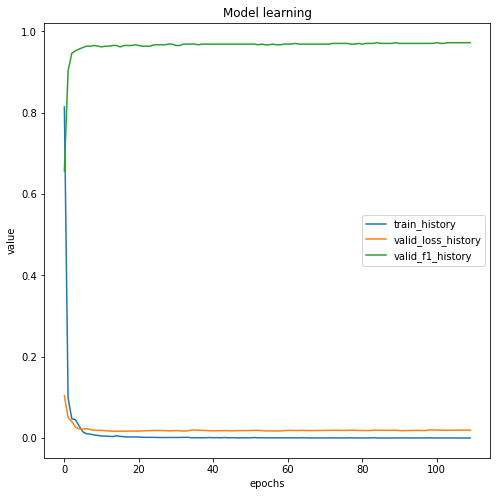

In [24]:
display_history(history)

In [25]:
test_idx = 0

In [26]:
rrrr = final_model.predict(dataset_dev.data_raw[test_idx])
print(rrrr)

{'words': ['West', 'Indian', 'all-rounder', 'Phil', 'Simmons', 'took', 'four', 'for', '38', 'on', 'Friday', 'as', 'Leicestershire', 'beat', 'Somerset', 'by', 'an', 'innings', 'and', '39', 'runs', 'in', 'two', 'days', 'to', 'take', 'over', 'at', 'the', 'head', 'of', 'the', 'county', 'championship', '.'], 'ner_tags': ['O', 'O', 'O', 'B', 'I', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'], 'text': 'West Indian all-rounder Phil Simmons took four for 38 on Friday as Leicestershire beat Somerset by an innings and 39 runs in two days to take over at the head of the county championship .', 'entities': [{'entity': 'Phil Simmons', 'offset': 24}], 'ner': ['O', 'O', 'O', 'B', 'I', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']}


In [27]:
rrrr['text'][rrrr['entities'][0]['offset']:]

'Phil Simmons took four for 38 on Friday as Leicestershire beat Somerset by an innings and 39 runs in two days to take over at the head of the county championship .'

In [28]:
ex_in_simple = dataset_dev.create_collate_fn()([dataset_dev[test_idx]])
predictions = final_model.model(
    input_ids = ex_in_simple['input_ids'].to(device), 
    attention_mask = ex_in_simple['attention_mask'].to(device),
    token_type_ids = ex_in_simple['token_type_ids'].to(device),
)
sample_predictions = final_model.model.get_indices(predictions).detach().cpu().tolist()[0]
print(sample_predictions)

[0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [29]:
dataset_train.tokenizer.tokenize('Andy Caddick')

['Andy', 'C', '##ad', '##dick']

In [30]:
dataset_train.tokenizer.decode( 
    dataset_train.tokenizer.encode('Andy Caddick')[1:-1]
)

'Andy Caddick'

In [31]:
test_model = Model2(device = device)

In [32]:
sample_generated = {
    'text': "The museum announced in late 2004 the selection of Pritzker Prizewinning architect Renzo Piano to design a new addition to the Gardner's campus. The new wing is currently under construction and scheduled to open to the public in early 2012. In addition to her responsibilities at the Isabella Stewart Gardner Museum, Ms. Hawley serves as a trustee on the boards of the Doris Duke Charitable Foundation, Save Venice, Inc., and the Fenway Alliance of Boston. Prior to her appointment to the Gardner, Anne Hawley founded the Cultural Education Collaborative, an organization dedicated to stimulating arts public policy and arts education."
}

resp = test_model.predict(sample_generated)

print(resp)

{'text': "The museum announced in late 2004 the selection of Pritzker Prizewinning architect Renzo Piano to design a new addition to the Gardner's campus. The new wing is currently under construction and scheduled to open to the public in early 2012. In addition to her responsibilities at the Isabella Stewart Gardner Museum, Ms. Hawley serves as a trustee on the boards of the Doris Duke Charitable Foundation, Save Venice, Inc., and the Fenway Alliance of Boston. Prior to her appointment to the Gardner, Anne Hawley founded the Cultural Education Collaborative, an organization dedicated to stimulating arts public policy and arts education.", 'entities': [{'entity': 'P', 'offset': 51}, {'entity': 'Renzo Piano', 'offset': 83}, {'entity': 'Isabella', 'offset': 284}, {'entity': '. Hawley', 'offset': 319}, {'entity': 'Doris Duke', 'offset': 369}, {'entity': 'Anne Hawley', 'offset': 498}], 'ner': ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'O', 'O', 'B', 'I', 'O', 'O', 'O', 'O', 'O', 'O